In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Carga de archivos

df_clientes = pd.read_csv(r"data/clean/clientes.csv")
df_productos = pd.read_csv(r"data/clean/productos.csv")
df_ventas = pd.read_csv(r"data/clean/ventas.csv")
df_detalle = pd.read_csv(r"data/clean/detalle_ventas.csv")


In [18]:
# Parsear fechas
df_ventas['fecha'] = pd.to_datetime(df_ventas['fecha'])
df_clientes['fecha_alta'] = pd.to_datetime(df_clientes['fecha_alta'])

# Fecha de referencia (última fecha en datos)
FECHA_REF = df_ventas['fecha'].max()
print(f"Fecha maxima: {FECHA_REF}")
print(f"Total clientes: {len(df_clientes)}")
print(f"Total ventas: {len(df_ventas)}")
print(f"Total productos: {len(df_productos)}")
print(f"Total líneas detalle: {len(df_detalle)}")

Fecha maxima: 2024-10-31 21:49:00
Total clientes: 1531
Total ventas: 113882
Total productos: 100
Total líneas detalle: 279528


In [19]:
# Join detalle con productos para categorías
df_full = df_detalle.merge(
    df_productos[['id_producto', 'categoria']], 
    on='id_producto',
    how='left'
)

# Join con ventas para fechas
df_full = df_full.merge(
    df_ventas[['id_venta', 'id_cliente', 'fecha']], 
    on='id_venta',
    how='left'
)

print(f"Dataset completo: {len(df_full)} registros")

Dataset completo: 279528 registros


#### Feature Engineering

In [20]:
# 1. FEATURES RFM

# Recency: días desde última compra
recency = df_full.groupby('id_cliente')['fecha'].max().reset_index()
recency['recency_dias'] = (FECHA_REF - recency['fecha']).dt.days
recency = recency[['id_cliente', 'recency_dias']]

# Frequency: número de compras únicas
frequency = df_ventas.groupby('id_cliente')['id_venta'].nunique().reset_index()
frequency.columns = ['id_cliente', 'frequency']

# # Monetary: gasto total
monetary = df_full.groupby('id_cliente')['importe'].sum().reset_index()
monetary.columns = ['id_cliente', 'monetary']

# Combinar RFM
features = recency.merge(frequency, on='id_cliente')
features = features.merge(monetary, on='id_cliente')

In [21]:
# 2. FEATURES DE COMPORTAMIENTO POR CATEGORÍA

# Gasto por cliente y categoría
gasto_categoria = df_full.groupby(['id_cliente', 'categoria'])['importe'].sum().reset_index()

# Pivot: categorías como columnas
gasto_pivot = gasto_categoria.pivot(
    index='id_cliente', 
    columns='categoria', 
    values='importe'
).fillna(0)

# Renombrar columnas
gasto_pivot.columns = [f'gasto_{col.lower().replace(" ", "_").replace("y", "").replace("__", "_")}' 
                       for col in gasto_pivot.columns]

# Calcular PORCENTAJES (más importante que valores absolutos)
gasto_total = gasto_pivot.sum(axis=1)
gasto_pct = gasto_pivot.div(gasto_total, axis=0) * 100
gasto_pct.columns = [col.replace('gasto_', 'pct_') for col in gasto_pct.columns]

# Merge con features
features = features.merge(gasto_pct, left_on='id_cliente', right_index=True, how='left')

In [22]:
# 3. FEATURES DE DIVERSIDAD
categoria_cols = [col for col in features.columns if col.startswith('pct_')]

# Diversidad de categorías (Shannon entropy)
def shannon_entropy(row):
    """Calcula entropía de Shannon para diversidad de categorías"""
    from scipy.stats import entropy
    probs = row[categoria_cols].values
    probs = probs[probs > 0]
    return entropy(probs)

features['diversidad_categorias'] = features.apply(shannon_entropy, axis=1)

In [23]:

# 3. FEATURES DE DIVERSIDAD
# Productos únicos comprados
productos_unicos = df_full.groupby('id_cliente')['id_producto'].nunique().reset_index()
productos_unicos.columns = ['id_cliente', 'productos_unicos']

# Productos por transacción (promedio)
productos_por_tx = df_full.groupby(['id_cliente', 'id_venta'])['id_producto'].count().reset_index()
productos_por_tx = productos_por_tx.groupby('id_cliente')['id_producto'].mean().reset_index()
productos_por_tx.columns = ['id_cliente', 'productos_por_transaccion']

# Merge
features = features.merge(productos_unicos, on='id_cliente', how='left')
features = features.merge(productos_por_tx, on='id_cliente', how='left')

# 5. FEATURES TEMPORALES
# Días promedio entre compras
fechas_por_cliente = df_full.groupby('id_cliente')['fecha'].unique().reset_index()

def calcular_dias_entre_compras(fechas):
    """Calcula promedio de días entre compras"""
    if len(fechas) <= 1:
        return 0
    fechas_sorted = sorted(fechas)
    diferencias = np.diff(fechas_sorted).astype('timedelta64[D]').astype(int)
    return np.mean(diferencias)

fechas_por_cliente['dias_entre_compras'] = fechas_por_cliente['fecha'].apply(
    calcular_dias_entre_compras
)
fechas_por_cliente = fechas_por_cliente[['id_cliente', 'dias_entre_compras']]

# Merge
features = features.merge(fechas_por_cliente, on='id_cliente', how='left')

In [24]:
# DEFINIR FEATURE SETS PARA CLUSTERING

# Excluir id_cliente
X_all = features.drop('id_cliente', axis=1)

In [25]:
X_all.columns

Index(['recency_dias', 'frequency', 'monetary', 'pct_bebidas',
       'pct_bebidas_alcohólicas', 'pct_congelados', 'pct_despensa',
       'pct_limpieza_cuidado', 'pct_lácteos_panadería', 'pct_snacks_golosinas',
       'diversidad_categorias', 'productos_unicos',
       'productos_por_transaccion', 'dias_entre_compras'],
      dtype='object')

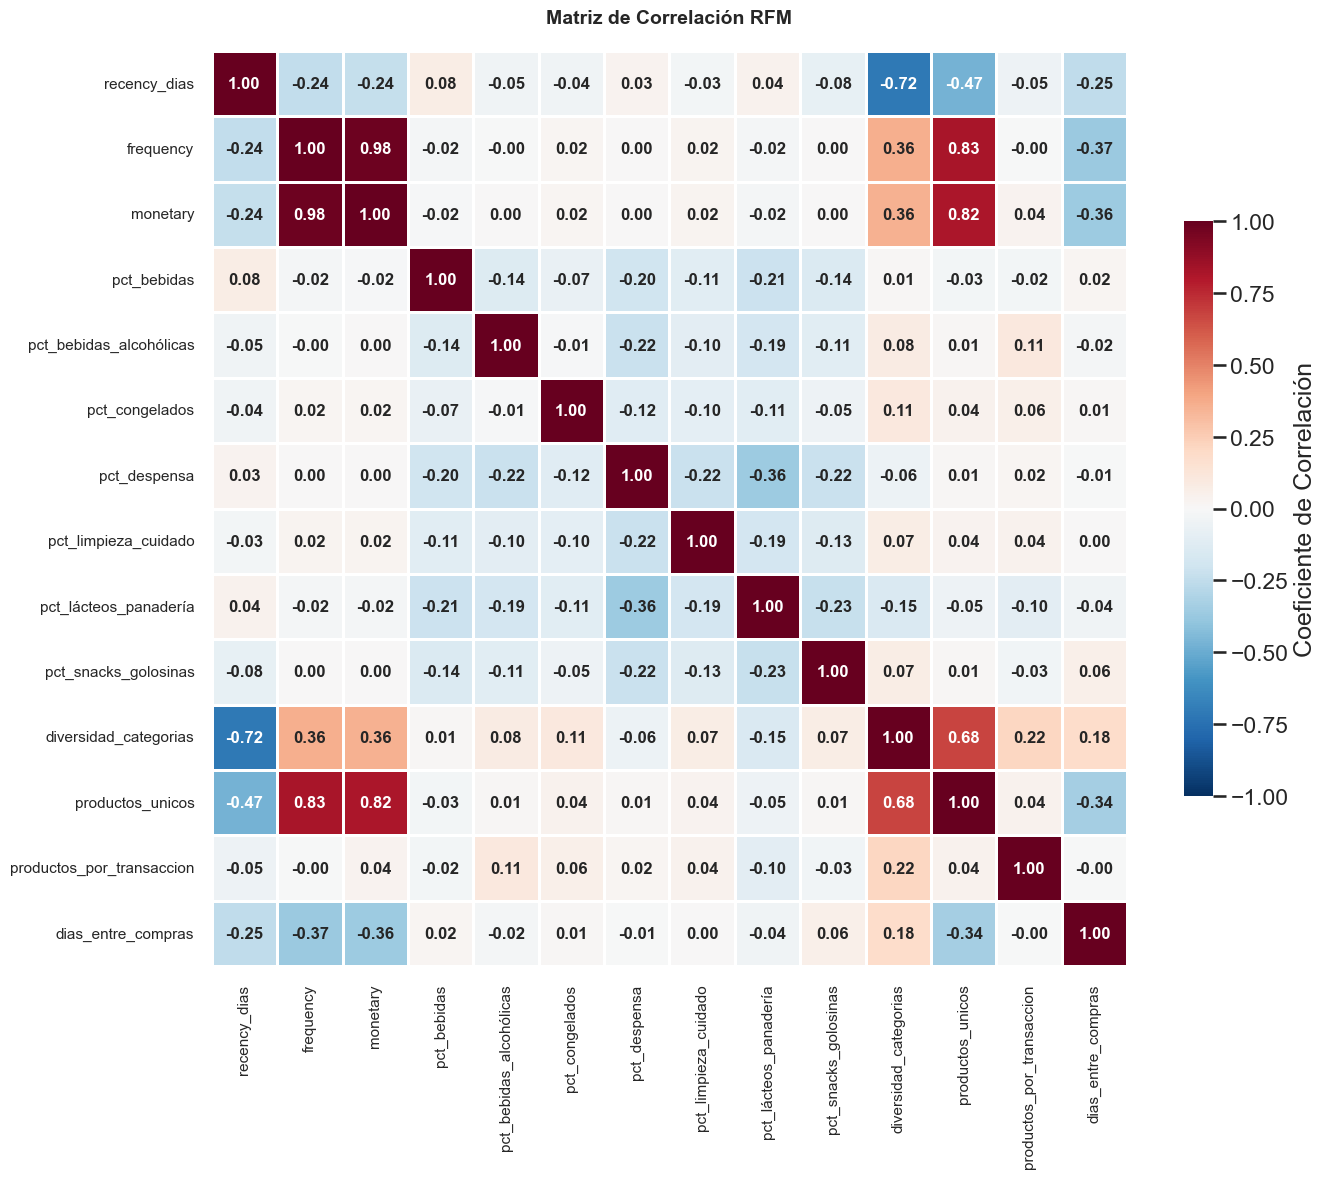

In [26]:
corr_matrix = X_all.corr()

# Visualización
fig, ax = plt.subplots(figsize=(14, 12))

# Visualizar la matriz con un mapa de calor más compacto
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', fmt=".2f",
            linewidths=1, vmin=-1, vmax=1, square=True,
            cbar_kws={'shrink': 0.6, 'label': 'Coeficiente de Correlación'},
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})

plt.title('Matriz de Correlación RFM', fontsize=14, fontweight='bold', pad=20)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

In [27]:

# Identificar correlaciones altas
print("\n🔍 Features con correlación alta (|r| > 0.5):")
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append({
                'feature_1': corr_matrix.columns[i],
                'feature_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

if high_corr:
    df_high_corr = pd.DataFrame(high_corr).sort_values('correlation', 
                                                        key=abs, 
                                                        ascending=False)
    print(df_high_corr.to_string(index=False))
else:
    print("   ✓ No hay correlaciones altas detectadas")



🔍 Features con correlación alta (|r| > 0.5):
   feature_1             feature_2  correlation
   frequency              monetary     0.982379
   frequency      productos_unicos     0.825490
    monetary      productos_unicos     0.815908
recency_dias diversidad_categorias    -0.717020


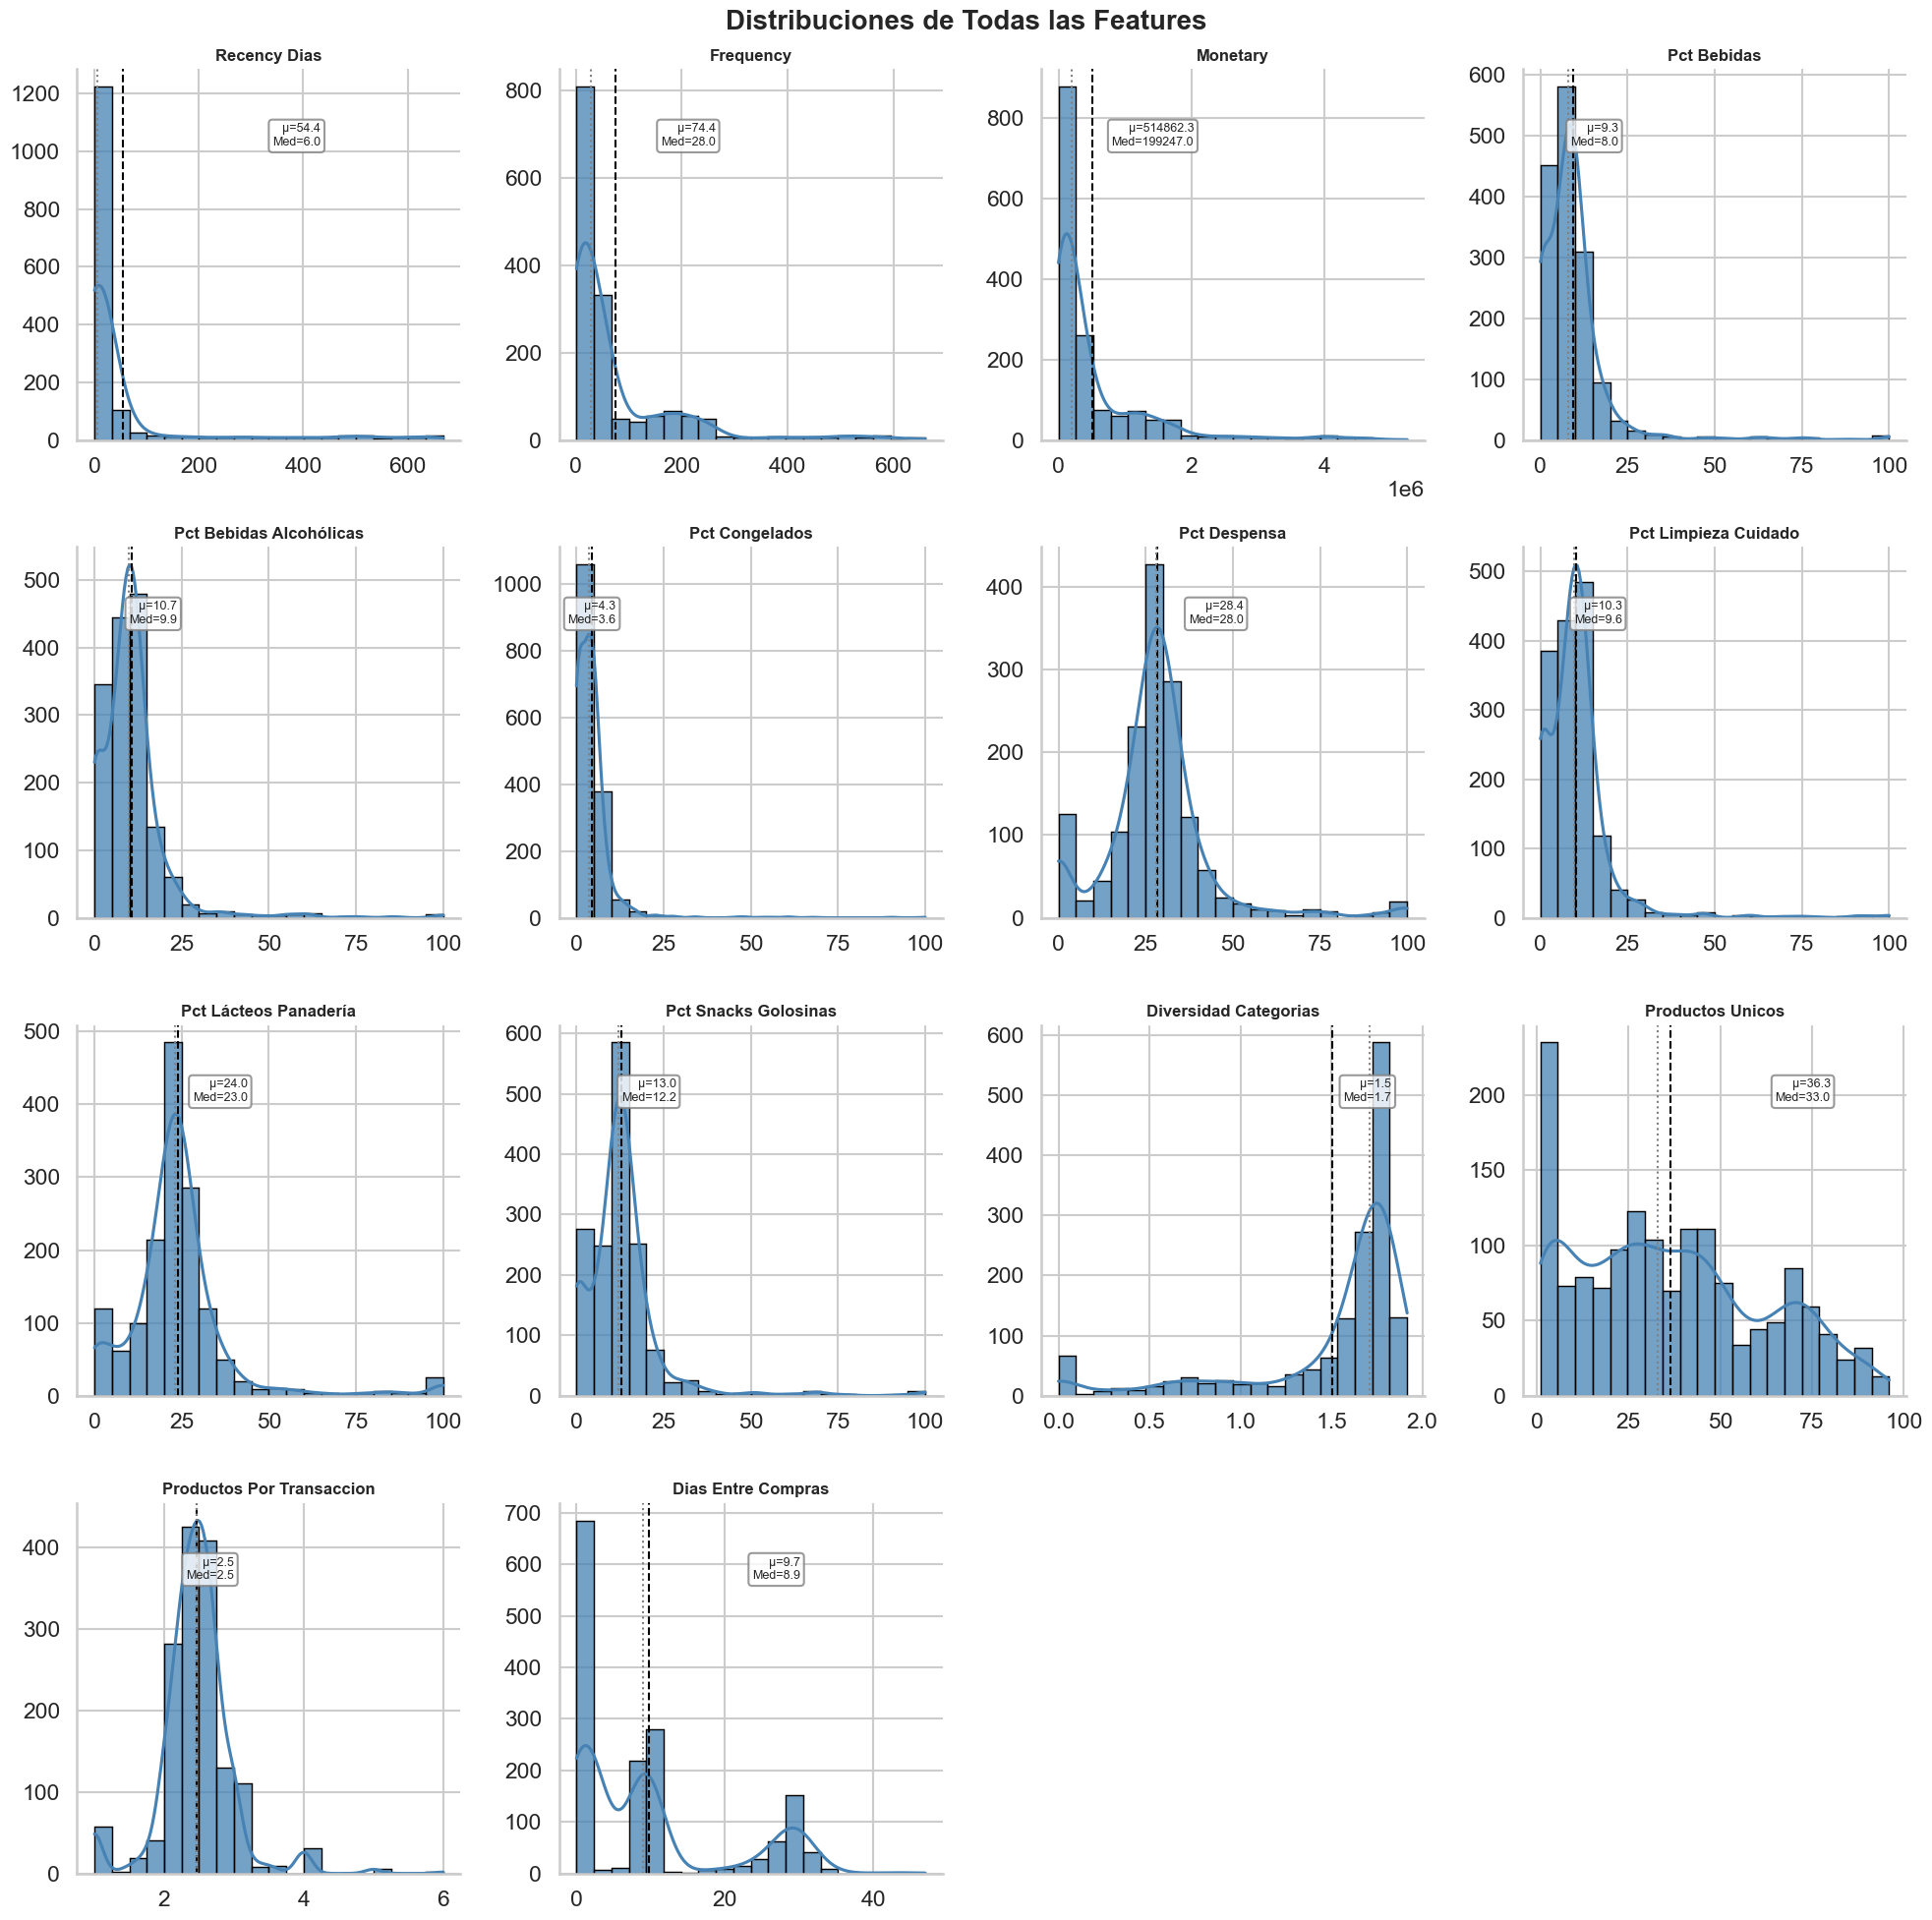

In [28]:
sns.set_style("whitegrid")
sns.set_context("talk")

# Crear una grilla más grande para acomodar 14 features
n_features = len(X_all.columns)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols  # Redondear hacia arriba

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
fig.suptitle('Distribuciones de Todas las Features', fontsize=20, weight='bold')
fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.4)

# Aplanar axes para facilitar iteración
axes = axes.flatten()

# Helper para dibujar media/mediana
def _annotate_stats(ax, data, xpos='right'):
    mean = data.mean()
    median = data.median()
    ymax = ax.get_ylim()[1]
    ax.axvline(mean, color='k', linestyle='--', linewidth=1.5)
    ax.axvline(median, color='gray', linestyle=':', linewidth=1.5)
    
    # Posición del texto
    x_text = data.quantile(0.95) if xpos == 'right' else data.quantile(0.05)
    ax.text(x_text, ymax*0.82, f"μ={mean:.1f}\nMed={median:.1f}", 
            ha='right' if xpos == 'right' else 'left', va='center',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8), 
            fontsize=9)

# Crear histogramas para cada feature
for idx, col in enumerate(X_all.columns):
    ax = axes[idx]
    
    # Histograma
    sns.histplot(X_all[col], bins=20, kde=True, 
                color='steelblue', alpha=0.75, edgecolor='k', ax=ax)
    
    # Títulos y etiquetas
    ax.set_title(col.replace('_', ' ').title(), fontsize=12, weight='semibold')
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Estadísticas
    _annotate_stats(ax, X_all[col])
    sns.despine(ax=ax)

# Ocultar ejes sobrantes si los hay
for idx in range(n_features, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

In [29]:
stats = pd.DataFrame({
    'feature': X_all.columns,
    'skewness': X_all.skew(),
    'kurtosis': X_all.kurtosis(),
    'min': X_all.min(),
    'max': X_all.max(),
    'zeros_%': (X_all == 0).sum() / len(X_all) * 100
}).round(3)

print(stats.to_string(index=False))

                  feature  skewness  kurtosis   min         max  zeros_%
             recency_dias     3.135     8.961   0.0     668.000   13.390
                frequency     2.607     7.536   1.0     660.000    0.000
                 monetary     2.785     8.877 272.0 5242937.000    0.000
              pct_bebidas     4.501    27.841   0.0     100.000   19.464
  pct_bebidas_alcohólicas     3.951    24.648   0.0     100.000   13.782
           pct_congelados     7.293    80.670   0.0     100.000   19.987
             pct_despensa     1.556     5.994   0.0     100.000    7.903
     pct_limpieza_cuidado     4.229    26.932   0.0     100.000   16.917
    pct_lácteos_panadería     2.447     9.791   0.0     100.000    5.291
     pct_snacks_golosinas     3.625    20.890   0.0     100.000   12.606
    diversidad_categorias    -1.962     2.866   0.0       1.917    4.311
         productos_unicos     0.371    -0.873   1.0      96.000    0.000
productos_por_transaccion     0.613     6.600   1.0

In [30]:
import pandas as pd

# Calcular outliers con regla 1.5*IQR para cada columna
outlier_stats = []

for col in X_all.columns:
    Q1 = X_all[col].quantile(0.25)
    Q3 = X_all[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_mask = (X_all[col] < lower_bound) | (X_all[col] > upper_bound)
    n_outliers = outliers_mask.sum()
    pct_outliers = (n_outliers / len(X_all)) * 100
    
    outlier_stats.append({
        'feature': col,
        'n_outliers': n_outliers,
        'pct_outliers': round(pct_outliers, 2),
        'lower_bound': round(lower_bound, 2),
        'upper_bound': round(upper_bound, 2)
    })

df_outliers = pd.DataFrame(outlier_stats).sort_values('pct_outliers', ascending=False)
print(df_outliers.to_string(index=False))

                  feature  n_outliers  pct_outliers  lower_bound  upper_bound
       dias_entre_compras         312         20.38        -9.50        21.17
                frequency         263         17.18       -78.00       154.00
    diversidad_categorias         244         15.94         1.08         2.20
             recency_dias         224         14.63       -29.50        54.50
             pct_despensa         219         14.30         6.05        49.22
    pct_lácteos_panadería         206         13.46         4.50        40.65
                 monetary         196         12.80   -674130.25   1275079.75
productos_por_transaccion         119          7.77         1.57         3.34
     pct_snacks_golosinas          86          5.62        -3.52        26.82
              pct_bebidas          78          5.09        -7.45        22.14
  pct_bebidas_alcohólicas          75          4.90        -5.16        23.81
     pct_limpieza_cuidado          74          4.83        -6.75

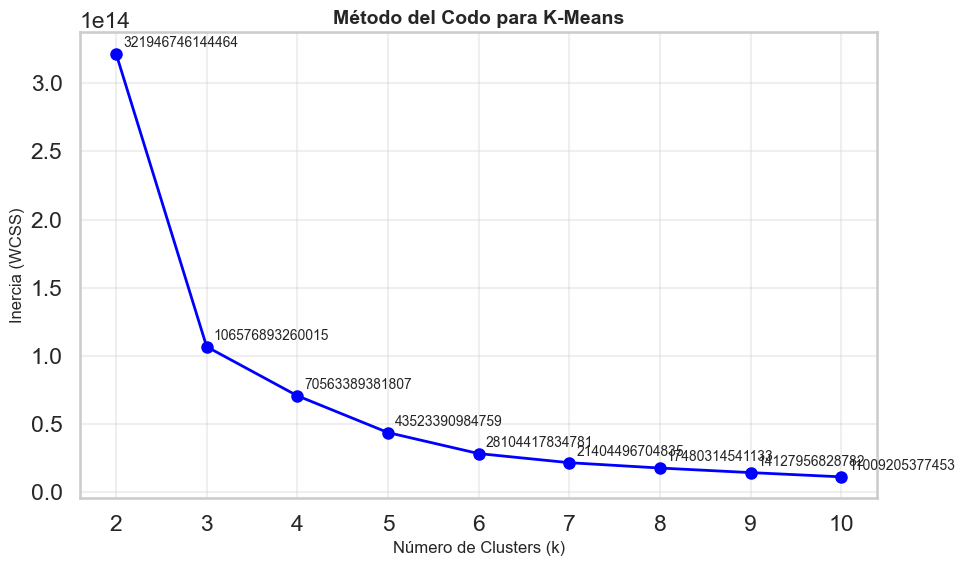

Análisis del Método del Codo:
    k       inertia     reduction
0   2  3.219467e+14  0.000000e+00
1   3  1.065769e+14  2.153699e+14
2   4  7.056339e+13  3.601350e+13
3   5  4.352339e+13  2.704000e+13
4   6  2.810442e+13  1.541897e+13
5   7  2.140450e+13  6.699921e+12
6   8  1.748031e+13  3.924182e+12
7   9  1.412796e+13  3.352358e+12
8  10  1.100921e+13  3.118751e+12


In [31]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_all)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [32]:
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Clustering
kmeans_no_scale = KMeans(n_clusters=3, random_state=42, n_init='auto')
labels_no_scale = kmeans_no_scale.fit_predict(X_all)

# Reducción dimensional para visualizar (PCA)
pca = PCA(n_components=2, random_state=42)
X_pca_no_scale = pca.fit_transform(X_all)

# Crear dataframe para plotly
df_plot_no_scale = pd.DataFrame({
    'PC1': X_pca_no_scale[:, 0],
    'PC2': X_pca_no_scale[:, 1],
    'Cluster': labels_no_scale.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values
})

# Plot
fig1 = px.scatter(
    df_plot_no_scale,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'Recency'],
    title=f'+Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig1.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [33]:
pd.DataFrame(labels_no_scale).value_counts()

0
0    1210
1     265
2      56
Name: count, dtype: int64

In [34]:
from sklearn.preprocessing import StandardScaler, RobustScaler

scaler = StandardScaler()
# scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_all)
X_train = pd.DataFrame(X_scaled, columns=X_all.columns)

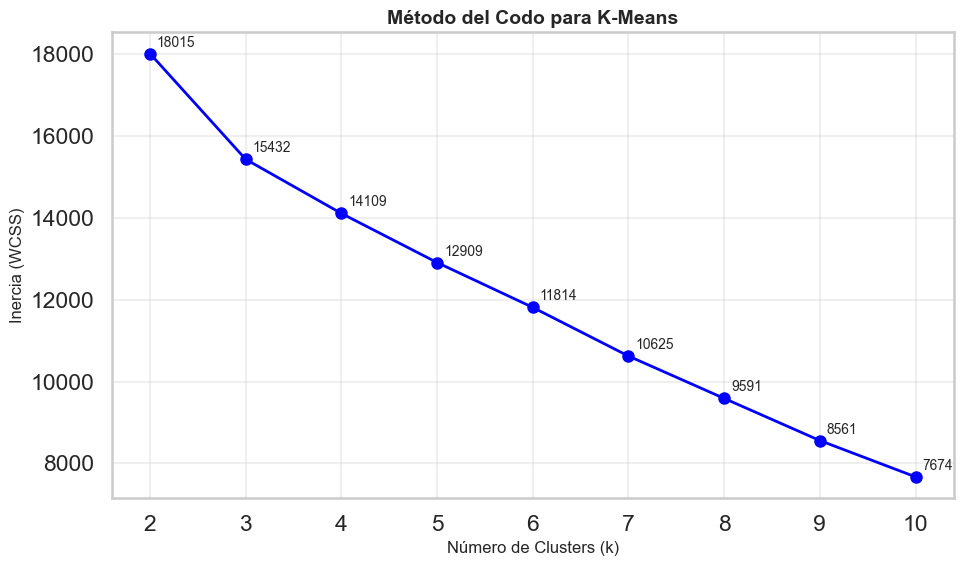

Análisis del Método del Codo:
    k   inertia  reduction
0   2  18015.20       0.00
1   3  15431.60    2583.59
2   4  14109.40    1322.20
3   5  12909.30    1200.10
4   6  11813.55    1095.75
5   7  10624.74    1188.81
6   8   9590.62    1034.12
7   9   8560.80    1029.82
8  10   7673.78     887.02


In [35]:
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

# Método del codo
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

# Gráfico del codo
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.title('Método del Codo para K-Means', fontsize=14, fontweight='bold')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.grid(True, alpha=0.3)

# Añadir valores en cada punto
for i, inertia in enumerate(inertias):
    plt.annotate(f'{inertia:.0f}', 
                xy=(K_range[i], inertia), 
                xytext=(5, 5), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# Mostrar tabla de resultados
elbow_results = pd.DataFrame({
    'k': K_range,
    'inertia': inertias,
    'reduction': [0] + [inertias[i-1] - inertias[i] for i in range(1, len(inertias))]
})

print("Análisis del Método del Codo:")
print(elbow_results.round(2))

In [36]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

results = []

for k in range(3, 10):
    # K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_km = kmeans.fit_predict(X_train)
    
    # Hierarchical
    hier = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_hier = hier.fit_predict(X_train)
    
    # Métricas
    for name, labels in [('kmeans', labels_km), ('hierarchical', labels_hier)]:
        results.append({
            'method': name,
            'k': k,
            'silhouette': silhouette_score(X_train, labels),
            'calinski': calinski_harabasz_score(X_train, labels),
            'davies': davies_bouldin_score(X_train, labels)
        })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

      method  k  silhouette   calinski   davies
      kmeans  3    0.250684 297.171365 1.863471
hierarchical  3    0.257100 276.896810 2.051820
      kmeans  4    0.262425 264.236437 1.755343
hierarchical  4    0.272263 248.853932 2.064222
      kmeans  5    0.283000 251.924770 1.642477
hierarchical  5    0.287539 241.627006 1.896546
      kmeans  6    0.292437 248.379728 1.406630
hierarchical  6    0.301802 243.342955 1.736748
      kmeans  7    0.312681 258.411121 1.456720
hierarchical  7    0.311337 248.470929 1.439013
      kmeans  8    0.275364 268.677188 1.409035
hierarchical  8    0.319923 252.755531 1.292899
      kmeans  9    0.285947 286.085915 1.272937
hierarchical  9    0.327073 262.881825 1.024234


In [37]:
# Clustering
X_all = X_all.drop('cluster', axis=1, errors='ignore')
kmeans_scaled = KMeans(n_clusters=7, random_state=42, n_init='auto')
labels_scaled = kmeans_scaled.fit_predict(X_train)

# PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca_scaled = pca2.fit_transform(X_train)

# Dataframe
df_plot_scaled = pd.DataFrame({
    'PC1': X_pca_scaled[:, 0],
    'PC2': X_pca_scaled[:, 1],
    'Cluster': labels_scaled.astype(str),
    'Monetary': X_all['monetary'].values,
    'Frequency': X_all['frequency'].values,
    'Recency': X_all['recency_dias'].values,
    'pct_despensa': X_all['pct_despensa'].values,
    'pct_bebidas_alcoh': X_all['pct_bebidas_alcohólicas'].values
})

# Plot
fig2 = px.scatter(
    df_plot_scaled,
    x='PC1', y='PC2',
    color='Cluster',
    hover_data=['Monetary', 'Frequency', 'pct_despensa', 'pct_bebidas_alcoh'],
    title=f'Varianza explicada: {pca2.explained_variance_ratio_.sum():.2%}',
    width=800, height=600
)
fig2.show()

c:\Users\Dell\anaconda3\envs\demo\lib\site-packages\plotly\express\_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [38]:
features['cluster'] = labels_scaled
features.groupby('cluster').mean().round(2)

,id_cliente,recency_dias,frequency,monetary,pct_bebidas,pct_bebidas_alcohólicas,pct_congelados,pct_despensa,pct_limpieza_cuidado,pct_lácteos_panadería,pct_snacks_golosinas,diversidad_categorias,productos_unicos,productos_por_transaccion,dias_entre_compras
cluster,,,,,,,,,,,,,,,
0,764.88,9.78,46.55,314836.87,8.95,11.39,4.31,28.28,10.41,23.56,13.09,1.69,38.68,2.47,7.28
1,734.68,316.35,1.17,8698.08,2.38,3.20,0.48,78.30,2.03,10.43,3.17,0.48,2.72,2.45,0.24
2,749.83,25.24,12.72,89586.14,9.19,10.32,4.16,28.77,10.88,23.22,13.46,1.56,19.58,2.48,28.19
3,820.82,299.15,1.06,6905.17,0.90,18.49,1.88,3.14,18.67,55.26,1.68,0.40,2.47,2.34,0.18
4,775.00,2.10,266.96,1863613.90,8.87,10.66,4.56,28.43,10.93,23.52,13.01,1.79,75.87,2.47,1.61
5,696.26,308.97,1.61,11953.10,72.01,2.89,0.78,10.50,2.32,7.17,4.33,0.64,3.35,2.42,4.66
6,839.35,236.12,1.70,11026.20,1.10,5.18,18.37,8.19,2.18,10.02,54.96,0.67,3.58,2.38,3.89


In [40]:
features.groupby('cluster')['cluster'].count()

cluster
0    689
1     71
2    322
3     88
4    290
5     31
6     40
Name: cluster, dtype: int64

In [ ]:
df_full = df_full.merge(
    features[['id_cliente', 'cluster']],
    on='id_cliente',
    how='left'
)

In [56]:
# Calcular umbrales desde los datos
umbral_dormido = features['recency_dias'].quantile(0.75)  # top 25% recency = dormidos
umbral_vip = features['frequency'].quantile(0.75)  # top 25% frequency = VIP
umbral_frecuente = features['frequency'].quantile(0.75)  # top 25% = frecuentes

print(f"Umbrales calculados:")
print(f"  Dormido (Q75): recency > {umbral_dormido:.0f} días")
print(f"  VIP (Q90): frequency > {umbral_vip:.0f} compras")
print(f"  Frecuente (Q60): frequency > {umbral_frecuente:.0f} compras")

# Calcular perfiles
profiles = features.groupby('cluster').agg({
    'recency_dias': 'mean',
    'frequency': 'mean',
    'monetary': 'mean',
    'pct_despensa': 'mean',
    'pct_bebidas_alcohólicas': 'mean',
    'pct_lácteos_panadería': 'mean',
    'pct_limpieza_cuidado': 'mean',
    'pct_snacks_golosinas': 'mean',
    'pct_bebidas': 'mean',
    'pct_congelados': 'mean'
})

# Función para etiquetar
def generar_etiqueta(row):
    # Estado
    if row['recency_dias'] > umbral_dormido:
        estado = "Dormido"
    elif row['frequency'] > umbral_vip:
        estado = "VIP"
    elif row['frequency'] > umbral_frecuente:
        estado = "Regular Frecuente"
    else:
        estado = "Regular Ocasional"
    
    # Categoría dominante
    categorias = {
        'Despensa': row['pct_despensa'],
        'Lácteos/Pan': row['pct_lácteos_panadería'],
        'Bebidas': row['pct_bebidas'],
        'Snacks': row['pct_snacks_golosinas'],
        'Limpieza': row['pct_limpieza_cuidado'],
        'Bebidas Alcoh': row['pct_bebidas_alcohólicas'],
        'Congelados': row['pct_congelados']
    }
    
    cat_dominante = max(categorias, key=categorias.get)
    pct_dominante = categorias[cat_dominante]
    
    # Si categoría dominante >40%, incluirla
    if pct_dominante > 40:
        return f"{estado} - {cat_dominante}"
    else:
        return estado

# Generar y aplicar etiquetas
etiquetas = {}
for cluster_id, row in profiles.iterrows():
    etiquetas[cluster_id] = generar_etiqueta(row)

features['cluster_nombre'] = features['cluster'].map(etiquetas)

print("\nEtiquetas generadas:")
for cluster_id, nombre in sorted(etiquetas.items()):
    n_clientes = (features['cluster'] == cluster_id).sum()
    print(f"Cluster {cluster_id}: {nombre} ({n_clientes} clientes)")

Umbrales calculados:
  Dormido (Q75): recency > 23 días
  VIP (Q90): frequency > 67 compras
  Frecuente (Q60): frequency > 67 compras

Etiquetas generadas:
Cluster 0: Regular Ocasional (689 clientes)
Cluster 1: Dormido - Despensa (71 clientes)
Cluster 2: Dormido (322 clientes)
Cluster 3: Dormido - Lácteos/Pan (88 clientes)
Cluster 4: VIP (290 clientes)
Cluster 5: Dormido - Bebidas (31 clientes)
Cluster 6: Dormido - Snacks (40 clientes)


In [46]:
for cluster_id in sorted(features['cluster'].unique()):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print('='*70)
    
    datos = df_full[df_full['cluster'] == cluster_id]
    top = datos.groupby('categoria').agg({
        'importe': 'sum',
        'cantidad': 'sum',
        'id_cliente': 'nunique'
    }).sort_values('importe', ascending=False).head(10)
    
    top.columns = ['Importe', 'Unidades', 'N_Clientes']
    print(top)


CLUSTER 0
                        Importe  Unidades  N_Clientes
categoria                                            
Despensa             62051186.0     37012         689
Lácteos y Panadería  51414926.0     51297         686
Snacks y Golosinas   28032665.0     19631         679
Bebidas Alcohólicas  23862309.0     16236         676
Limpieza y Cuidado   22449947.0     14163         667
Bebidas              19603196.0      7728         642
Congelados            9508375.0      8424         647

CLUSTER 1
                      Importe  Unidades  N_Clientes
categoria                                          
Despensa             439256.0       206          71
Lácteos y Panadería   85139.0       100          39
Snacks y Golosinas    31572.0        22          16
Bebidas Alcohólicas   21786.0        20          11
Bebidas               19290.0         7           6
Limpieza y Cuidado    18694.0        15           6
Congelados             1827.0         4           4

CLUSTER 2
             